## CUSTCNN



## TODO

boxes genormaliseerd maar fotogrootte niet. Mismatch?  
geeft betere resultaten dan niet genormaliseerde boxes.  
- [x] gebruikt maken van test en validatieset &rarr; automatisch stoppen training bij bepaalde validation loss  - meer epochs nemen  
- dense layers onderzoeken tussen convolution  
- activatiefuncties
- [x] deftig maken CNN layers
- [x] pre processing met edge detection?
- [x] verifieren of Canny correct uitgevoerd wordt
- [x] verschil tussen canny en niet kijken
- [x] manueel slechte images weghalen
- [x] visualiseren van layers
- [ ] visualiserne filters
- [ ] verfijnen netwerk
- [ ] eens naar RMSE trainen
- [ ] Negatives toevoegen aan dataset invloed? (later)

### Bronnen
https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/  
https://pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/  
https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/  
https://www.youtube.com/watch?v=6wcs6szJWMY

In [9]:
import os
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn import metrics as me
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 

In [10]:
#BASE_PATH = '/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/Oefenen/MaskRCNN/data'

BASE_PATH = '/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/CustCNN'
DATA_PATH = os.path.sep.join([BASE_PATH, "Trimmeddata_bigger_test"])
TRAIN_IMAGES_PATH = os.path.sep.join([DATA_PATH, "trainval/images"])
print(TRAIN_IMAGES_PATH)
TRAIN_ANNOTS_PATH = os.path.sep.join([DATA_PATH, "trainval/_annotations.csv"])
print(TRAIN_ANNOTS_PATH)



NUM_EPOCHS = 50                                                                      
BATCH_SIZE = 32
IMAGE_SIZE = 224
CANNY = False
CHANNELS = 3

/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/CustCNN/Trimmeddata_bigger_test/trainval/images
/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/CustCNN/Trimmeddata_bigger_test/trainval/_annotations.csv


In [11]:
#fotos
data = []
#coordinaten
targets = []
#files
filenames = []

In [12]:
#annotaties inladen
df=pd.read_csv(TRAIN_ANNOTS_PATH)
df = df.drop('class', axis=1)
df = df.drop('width', axis=1)
df = df.drop('height', axis=1)
df.head(20)

,filename,xmin,ymin,xmax,ymax
0,3c95b9d96507d903_jpg.rf.fd29e5454becead6f000ee...,112,147,302,230
1,3ea01f40bd6e732b_jpg.rf.fc8d71f54b992246c53a9d...,196,80,383,220
2,db2475b71f8caef3_jpg.rf.fd26b126389c3aac05f436...,189,0,252,108
3,13e0df4b94cf670a_jpg.rf.fd1e65aede53ce2eef853b...,38,226,266,399
4,97b23fd01e078f4e_jpg.rf.fcf10b4c55ba55041bf020...,47,21,278,148
5,187b328c7816d4f2_jpg.rf.fd5d0deaa5b494b727e3c1...,62,7,402,415
6,854062ff0a778de2_jpg.rf.fcbc173d997b87b7c4a74e...,92,18,321,278
7,4fbb904fc70b9522_jpg.rf.fd97c513d6b2f2384c7d05...,63,110,351,326
8,d17aeb78d03dcb7c_jpg.rf.fcaec6a85c03127be8cc90...,22,29,373,380
9,5a91555e07cab9c0_jpg.rf.fd7d420640c107d88927c5...,20,46,400,349


### Pre-Processing
**Elk datapunt in de csv wordt overlopen. Uit csv worden fotos gehaald die in lijst worden gestoken.**

- groottes normaliseren voor betere werking netwerk 
- canny edge detection wordt op elke foto uitgevoerd (verifieren of die goed werkt)

In [13]:
# loop over the rows
#totmaxx = 0
#totmaxy = 0

rows=[]
for index, row in df.iterrows():
        # data uit annotaties halen
    (filename, startX, startY, endX, endY) = row
    rows.append(row) 

        # foto inladen
    imagePath = os.path.sep.join([TRAIN_IMAGES_PATH, filename])
    #print(imagePath)
    image = cv2.imread(imagePath)
    #cv2.imshow('image', image)
    
        #normalisatie: bounding box coordinaten worden gescaled volgen de imagegrootte
    (h, w) = image.shape[:2]
    startX = (float(startX) / w)
    startY = (float(startY) / h)
    endX = (float(endX) / w)
    endY = (float(endY) / h)
    
    #totmaxx = totmaxx + endX
    #totmaxy = totmaxy + endY
    
    #print("normalized", startX, startY, endX, endY)
    image = np.array((load_img(imagePath, target_size=(IMAGE_SIZE, IMAGE_SIZE))))
         #Canny edge detection uitvoeren bij bool
    if CANNY:
        CHANNELS = 1
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #1 kanaals maken
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)    #blurren voor beter resultaat

        # Canny edge detection
        canny = cv2.Canny(blurred, 50, 180, 1)
   
        image = img_to_array(canny)
    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)
    #voor elke bounding box in image wordt de foto opnieuw toegevoegd
    #print("image in lijst:" ,targets[0])
    #print("image in lijst:" ,image.shape)

print(len(data))
#print(targets[0])
#print(data[0].shape)
#print(totmaxx/len(data))
#print(totmaxy/len(data))

1679


### #datapunten eerste poging
- gebruikt train dataset  
- 23914 annotaties dataset bevat 5537 fotos

### #datapunten tweede poging
- gebruikt train dataset  
- 2390 annotaties dataset bevat 2390 fotos
### Derde poging
- elke foto naar edge detected foto omzetten

### Vierde poging
- edge detection binnen netwerk proberen uitvoeren
- automatisch stoppen bij niet beteren loss
- 50 epochs

In [14]:
    # data(pixel intensiteit) normaliseren en naar numpy arrays omzetten
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
split = train_test_split(data, targets, filenames, test_size=0.1,random_state=42)
    # unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

### Layers

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout

#create model
model = Sequential()
#add model layers

model.add(Conv2D(32, kernel_size=7, activation="relu", padding="same", input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))
model.add(MaxPooling2D())

model.add(Conv2D(32, kernel_size=3, activation="relu", padding="same"))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, kernel_size=3, activation="relu", padding="same"))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, kernel_size=3, activation="relu", padding="same"))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, kernel_size=3, activation="relu", padding="same"))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
#model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
#model.add(Dense(16, activation="relu"))
model.add(Dense(4, activation="sigmoid"))               #eindigen op 4 nodes 
print("output shape:", model.output_shape)

"""

model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

"""
print(trainImages.shape)
print(trainTargets.shape)
print(testImages.shape)
print(testTargets.shape)

output shape: (None, 4)
(1511, 224, 224, 3)
(1511, 4)
(168, 224, 224, 3)
(168, 4)


In [16]:
    # initialize the optimizer, compile the model, and show the model
    # summary
opt = Adam()
model.compile(loss="mse", optimizer=opt)
    # stop when no validation loss improvement in 5 epochs
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
print(model.summary())
    # train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    #callbacks=[es]
    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      4736      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 32)      

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


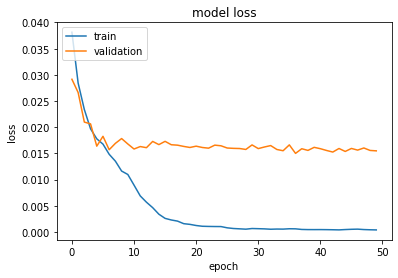

In [19]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('/Users/stefgielen/Documents/school 2021-2022/thesis/Docs/Beelden Thesis/Werkwijze/losses.eps', format='eps')
plt.show()
#wss veel betere loss bij grote trainingset -> moet eens tijd voor maken
#convergeert (nog) niet

In [10]:
model.save("modeltestset_bigtest")

2022-05-15 10:39:32.229074: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: modeltestset_bigtest/assets


In [11]:
from tensorflow.keras.models import load_model
model = load_model("modeltestset_bigtest")

In [12]:
pred = model.predict(testImages)
#print(pred)

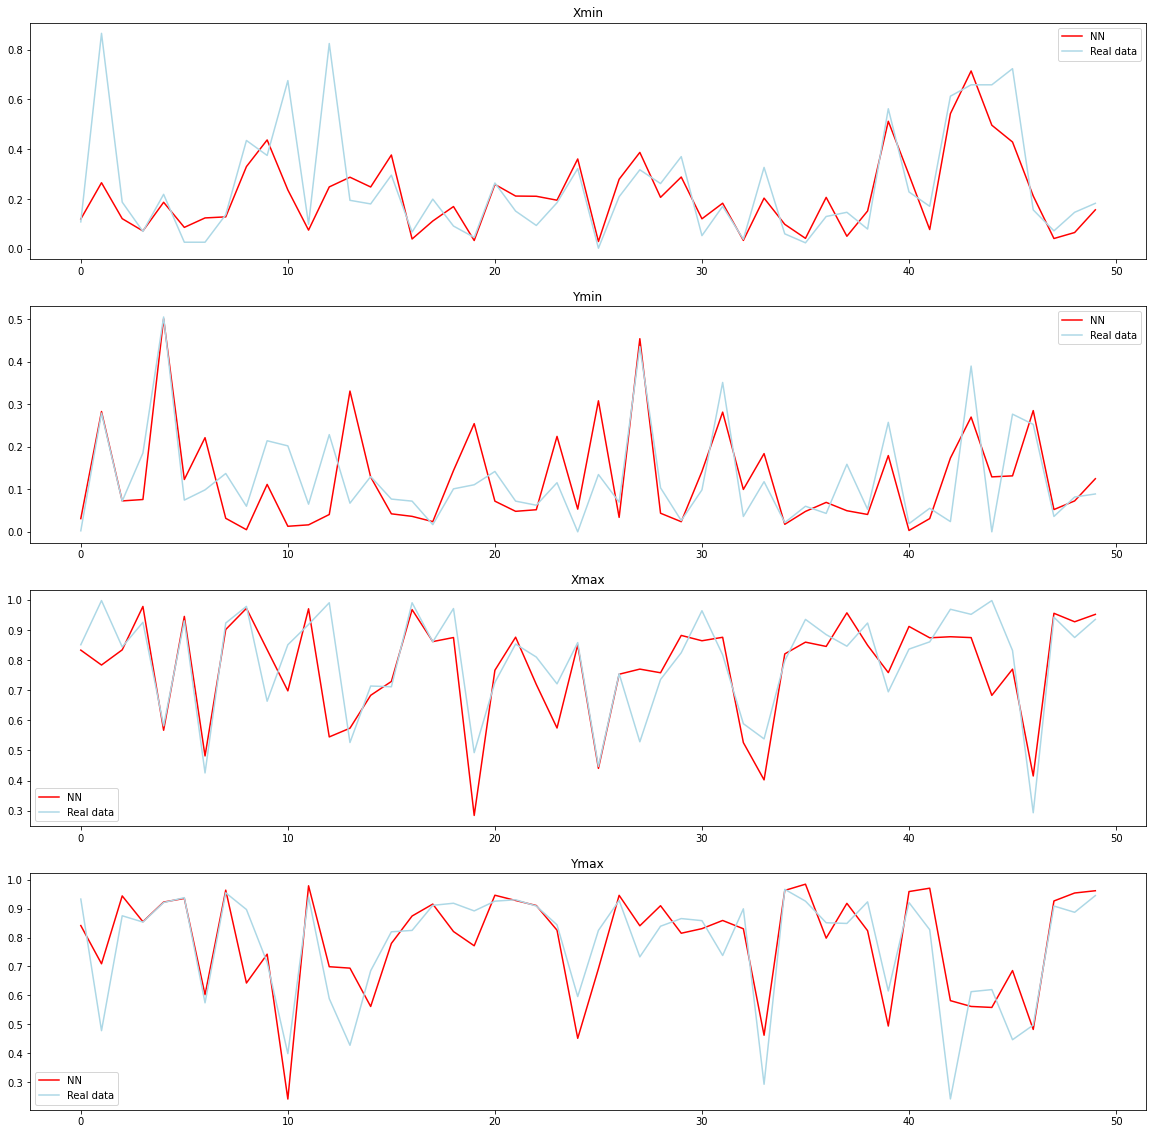

In [13]:
plt.rcParams["figure.figsize"] = (20,20)
fig, axs = plt.subplots(4, 1)

axs[0].plot(pred[:50,0], color = 'red', label = 'NN')
axs[0].plot(testTargets[:50,0], color = 'lightblue', label = 'Real data')
axs[0].set_title('Xmin')
axs[0].legend()

axs[1].plot(pred[:50,1], color = 'red', label = 'NN')
axs[1].plot(testTargets[:50,1], color = 'lightblue', label = 'Real data')
axs[1].set_title('Ymin')
axs[1].legend()

axs[2].plot(pred[:50,2], color = 'red', label = 'NN')
axs[2].plot(testTargets[:50,2], color = 'lightblue', label = 'Real data')
axs[2].set_title('Xmax')
axs[2].legend()

axs[3].plot(pred[:50,3], color = 'red', label = 'NN')
axs[3].plot(testTargets[:50,3], color = 'lightblue', label = 'Real data')
axs[3].set_title('Ymax')
axs[3].legend()
plt.show()

In [14]:
print("Mae: ",me.mean_absolute_error(testTargets, pred))
print("Mse: ",me.mean_squared_error(testTargets, pred))
print("Rmse: ",np.sqrt(me.mean_squared_error(testTargets, pred)))

#zeker niet goed genoeg

Mae:  0.07717586
Mse:  0.013853678
Rmse:  0.11770165


### Resultaten
#### Oud netwerk:
**xmin en ymin liggen telkens op 0**  
vreemd resultaat aangezien de gemiddelde x waarde 0.21 is  
en de gemiddelde y waarde 0.16  
maxima liggen elk rond 0.78 dus predictions zijn ook heel laag  
Resultaten zijn dus niet echt verwacht. 

#### Derde netwerk 50 epochs
Mae:  0.103151366  
Mse:  0.024586797  
Rmse:  0.15680178

#### vierde netwerk, manueel aangepaste dataset
Mae:  0.07477908  
Mse:  0.0126632415  
Rmse:  0.112531066  

#### Vijfde netwerk specifiek ontworpen
